In [1]:
import pandas as pd
import numpy as np
import os
import re

RAW_PATH = "/Users/dornanikshad/fashionphile_hermes_bags.csv"

df = pd.read_csv(RAW_PATH)
df.shape, df.columns

((999, 13),
 Index(['title', 'model', 'sell_price', 'condition', 'sku', 'status', 'brand',
        'description', 'leather', 'hardware', 'color', 'size_cm', 'url'],
       dtype='object'))

In [2]:
df.head()
df.info()
(df.isna().mean().sort_values(ascending=False) * 100).round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        999 non-null    object 
 1   model        999 non-null    object 
 2   sell_price   999 non-null    float64
 3   condition    999 non-null    object 
 4   sku          999 non-null    int64  
 5   status       0 non-null      float64
 6   brand        999 non-null    object 
 7   description  948 non-null    object 
 8   leather      730 non-null    object 
 9   hardware     341 non-null    object 
 10  color        999 non-null    object 
 11  size_cm      718 non-null    float64
 12  url          999 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 101.6+ KB


status         100.00
hardware        65.87
size_cm         28.13
leather         26.93
description      5.11
title            0.00
model            0.00
sell_price       0.00
condition        0.00
sku              0.00
brand            0.00
color            0.00
url              0.00
dtype: float64

In [3]:
df = df.drop(columns=["status"], errors="ignore")

# Normalize whitespace in text columns
text_cols = ["title", "model", "condition", "sku", "brand", "description", "leather", "hardware", "color", "url"]
for c in text_cols:
    if c in df.columns:
        df[c] = (
    df[c]
    .astype("string")
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

In [4]:
# Ensure sku is string (ID)
df["sku"] = df["sku"].astype("string")

# Ensure sell_price numeric
df["sell_price"] = pd.to_numeric(df["sell_price"], errors="coerce")

# Ensure size numeric
df["size_cm"] = pd.to_numeric(df["size_cm"], errors="coerce")

In [5]:
df[["sell_price", "size_cm"]].describe()

,sell_price,size_cm
count,999.000000,718.000000
mean,11765.465465,50.541783
std,12572.398352,213.214752
min,85.000000,16.000000
25%,3242.500000,20.000000
50%,6990.000000,25.000000
75%,16930.000000,31.000000
max,139995.000000,2002.000000


In [6]:
df["description"] = df["description"].fillna("")

df["leather"] = df["leather"].fillna("Unknown")
df["hardware"] = df["hardware"].fillna("Unknown")

size_median = df["size_cm"].median()
df["size_cm"] = df["size_cm"].fillna(size_median)
size_median

25.0

In [7]:
before = df.shape[0]

df = df.drop_duplicates(subset=["url"], keep="first")
df = df.drop_duplicates(subset=["sku"], keep="first")

after = df.shape[0]
before, after, before - after

(999, 999, 0)

In [8]:
df = df[df["size_cm"]< 45]
df.shape

(984, 12)

In [9]:
df = df[df["sell_price"].notna()]
df = df[df["sell_price"] > 0]
df.shape

(984, 12)

In [10]:
# keep only reasonable range (adjust threshold if needed)
df = df[df["sell_price"]< 40000]
df = df[df["sell_price"]> 200]
df.shape

(919, 12)

In [11]:
# Quick value checks for key categorical columns
for col in ["condition", "leather", "hardware", "color"]:
    if col in df.columns:
        print(f"\n{col.upper()}")
        print(df[col].value_counts(dropna=False).head(10))



CONDITION
condition
Excellent     495
Shows Wear    361
Giftable       52
New            10
Worn            1
Name: count, dtype: Int64

LEATHER
leather
Unknown     238
Clemence    233
Epsom       172
Togo        137
Swift        82
Chevre       35
Box          22
Name: count, dtype: Int64

HARDWARE
hardware
Unknown      600
Palladium    162
Gold          82
Silver        75
Name: count, dtype: Int64

COLOR
color
Black     125
Gold       88
Etoupe     51
Orange     24
Fauve      20
Craie      19
H          16
Lime       14
Etain      14
White      12
Name: count, dtype: Int64


In [12]:
df["hardware"] = df["hardware"].replace({
    "Silver": "Palladium"
})
df["hardware"].value_counts()

hardware
Unknown      600
Palladium    237
Gold          82
Name: count, dtype: Int64

In [13]:
df.loc[df["color"] == "H", "color"] = "Unknown"

In [14]:
df["condition"] = df["condition"].replace({
    "Worn": "Good",
    "Shows Wear": "Very Good",
    "Giftable": "Excellent",
})
df["condition"].value_counts()

condition
Excellent    547
Very Good    361
New           10
Good           1
Name: count, dtype: Int64

In [15]:
for col in ["condition", "leather", "hardware", "color"]:
    print(f"\n{col.upper()}")
    print(df[col].value_counts().head(10))


CONDITION
condition
Excellent    547
Very Good    361
New           10
Good           1
Name: count, dtype: Int64

LEATHER
leather
Unknown     238
Clemence    233
Epsom       172
Togo        137
Swift        82
Chevre       35
Box          22
Name: count, dtype: Int64

HARDWARE
hardware
Unknown      600
Palladium    237
Gold          82
Name: count, dtype: Int64

COLOR
color
Black      125
Gold        88
Etoupe      51
Orange      24
Fauve       20
Craie       19
Unknown     16
Lime        14
Etain       14
White       12
Name: count, dtype: Int64


In [16]:
df["sell_price"].describe()

count      919.000000
mean     11179.243743
std       9525.053274
min        250.000000
25%       3495.000000
50%       7415.000000
75%      16542.500000
max      39895.000000
Name: sell_price, dtype: float64

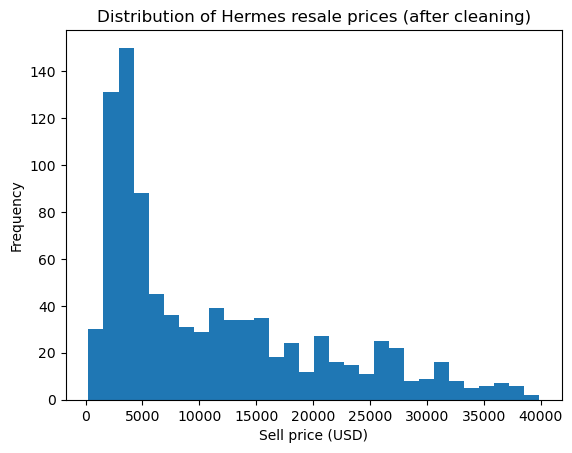

In [17]:
import matplotlib.pyplot as plt

df["sell_price"].plot(kind="hist", bins=30)
plt.xlabel("Sell price (USD)")
plt.title("Distribution of Hermes resale prices (after cleaning)")
plt.show()

In [18]:
(df.isna().mean().sort_values(ascending=False) * 100).round(2)

title          0.0
model          0.0
sell_price     0.0
condition      0.0
sku            0.0
brand          0.0
description    0.0
leather        0.0
hardware       0.0
color          0.0
size_cm        0.0
url            0.0
dtype: float64

In [19]:
MODEL_COLS = [
    "sell_price",
    "size_cm",
    "condition",
    "leather",
    "hardware",
    "color",
    "brand",
    "model",
    "sku",
    "url",
]

df_model = df[MODEL_COLS].copy()
df_model.shape

(919, 10)

In [20]:
CLEAN_PATH = "/Users/dornanikshad/fashionphile_hermes_clean.csv"

df_model.to_csv(CLEAN_PATH, index=False)

CLEAN_PATH, df_model.shape

('/Users/dornanikshad/fashionphile_hermes_clean.csv', (919, 10))